# Test 

We test the IAST code with a binary mixture of methane (CH$_4$) and ethane (C$_2$H$_6$) in IRMOF-1.

Simulated pure-component adsorption isotherms at 298 K are present in:
* `IRMOF-1_clean_CH4_isotherm_298K.csv`
* `IRMOF-1_clean_CH3CH3_isotherm_298K.csv`

We ran dual component GCMC mixture isotherms of methane/ethane in IRMOF-1 at 65 bar total pressure and 298 K at different mixture compositions. This data is present in `IRMOF-1_clean_298K_CH4_CH3CH3_mixture.csv`.

The goal of this test is to use pyIAST to predict the mixture isotherms from the pure-component isotherms and compare to the binary GCMC mixture simulations.

In [47]:
import IAST
import pandas as pd
import matplotlib
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')
matplotlib.rc('axes', facecolor='w') # Or any suitable colour...
matplotlib.rc('lines',linewidth=3)
matplotlib.rc('font', size=16)
 
%matplotlib inline
%pylab inline

%config InlineBackend.rc = {'font.size': 16, 'lines.linewidth':3}

# for plots
color_key = {'methane':'g', 'ethane':'r'}

Populating the interactive namespace from numpy and matplotlib


## Load pure component isotherms as Pandas dataframes

First, retreive crystal denstiy of structure.

In [48]:
rho = float(open("IRMOF-1_clean_CH4_isotherm_298K.csv").readline().split()[2])  # kg/m3

### Methane

In [49]:
df_ch4 = pd.read_csv("IRMOF-1_clean_CH4_isotherm_298K.csv", skiprows=1)
# to work with more convenient units
df_ch4['Pressure(bar)'] = df_ch4['Pressure(Pa)'] / 100000.0
df_ch4['Loading(mol/kg)'] = df_ch4['Loading(mol/m3)'] / rho
df_ch4.head()

,Pressure(Pa),Loading(mol/m3),Pressure(bar),Loading(mol/kg)
0,10,0.023484,0.0001,0.000040
1,100,0.289035,0.0010,0.000487
2,1000,2.472450,0.0100,0.004167
3,10000,25.930619,0.1000,0.043705
4,20000,52.462791,0.2000,0.088424


### Ethane

In [50]:
df_ch3ch3 = pd.read_csv("IRMOF-1_clean_CH3CH3_isotherm_298K.csv", skiprows=1)
# to work with more convenient units
df_ch3ch3['Pressure(bar)'] = df_ch3ch3['Pressure(Pa)'] / 100000.0
df_ch3ch3['Loading(mol/kg)'] = df_ch3ch3['Loading(mol/m3)'] / rho
df_ch3ch3.head()

,Pressure(Pa),Loading(mol/m3),Pressure(bar),Loading(mol/kg)
0,10,0.106582,0.0001,0.000180
1,100,1.049557,0.0010,0.001769
2,1000,10.335998,0.0100,0.017421
3,10000,106.316062,0.1000,0.179192
4,20000,218.537279,0.2000,0.368338


### Plot isotherm data

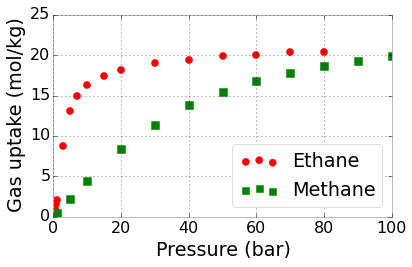

In [51]:
fig = plt.figure()
plt.scatter(df_ch3ch3['Pressure(bar)'], df_ch3ch3['Loading(mol/kg)'], 
            label='Ethane', color=color_key['ethane'], s=50)
plt.scatter(df_ch4['Pressure(bar)'], df_ch4['Loading(mol/kg)'], 
            label='Methane', color=color_key['methane'], s=50, marker='s')
plt.xlabel('Pressure (bar)')
plt.ylabel('Gas uptake (mol/kg)')
plt.legend(loc='lower right')
plt.xlim([0, 100])
plt.ylim(ymin=0)
plt.tight_layout()
plt.show()

## Import binary-component GCMC mixture isotherms

In [52]:
df_mix = pd.read_csv("IRMOF-1_clean_298K_CH4_CH3CH3_mixture.csv")
# to work with more convenient units
df_mix["LoadingCH3CH3(mol/kg)"] = df_mix["LoadingCH3CH3(mol/m3)"] / rho
df_mix["LoadingCH4(mol/kg)"] = df_mix["LoadingCH4(mol/m3)"] / rho
# define gas phase mole fraction
df_mix["y_CH3CH3"] = df_mix["p_CH3CH3(Pa)"] / (df_mix["p_CH3CH3(Pa)"] + df_mix["p_CH4(Pa)"])
df_mix.head()

,p_CH3CH3(Pa),p_CH4(Pa),LoadingCH3CH3(mol/m3),LoadingCH4(mol/m3),LoadingCH3CH3(mol/kg),LoadingCH4(mol/kg),y_CH3CH3
0,10000,6490000,86.809663,10245.026337,0.146315,17.267679,0.001538
1,50000,6450000,430.043458,9966.957157,0.724825,16.799002,0.007692
2,100000,6400000,847.832769,9608.445881,1.428996,16.194742,0.015385
3,200000,6300000,1638.684436,9026.572648,2.761953,15.214012,0.030769
4,300000,6200000,2365.698251,8490.400097,3.987312,14.310310,0.046154


### Plot mixture data

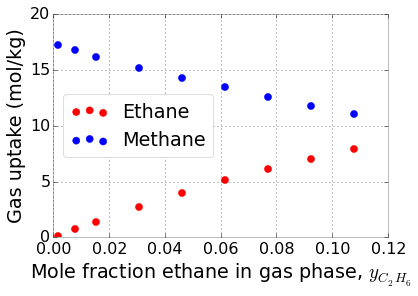

In [53]:
fig = plt.figure()
plt.xlabel('Mole fraction ethane in gas phase, $y_{C_2H_6}$')
plt.ylabel('Gas uptake (mol/kg)')
plt.scatter(df_mix['y_CH3CH3'], df_mix['LoadingCH3CH3(mol/kg)'], color='r', label='Ethane', s=50)
plt.scatter(df_mix['y_CH3CH3'], df_mix['LoadingCH4(mol/kg)'], color='b', label='Methane', s=50)
plt.ylim(ymin=0)
plt.xlim([0, .12])
plt.legend(loc='center left')
plt.show()

## Use IAST to predict mixture data, compare to dual component GCMC

Construct isotherm objects. Use the interpolator isotherm here, as Langmuir and Quadratic isotherms do not fit well.

We use fill_value = largest loading so that, when the linear interpolation routine calls a pressure beyond our data, it will yield this value. Essentially, the assumption is that the saturation loading = the highest loading observed in the data.

### Interpolator isotherm for Methane

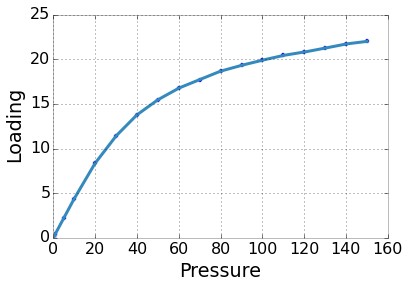

In [54]:
ch4_isotherm = IAST.InterpolatorIsotherm(df_ch4, loading_key="Loading(mol/kg)", pressure_key="Pressure(bar)", fill_value=df_ch4['Loading(mol/kg)'].max())
IAST.plot_isotherm(ch4_isotherm)

### Interpolator isotherm for ethane

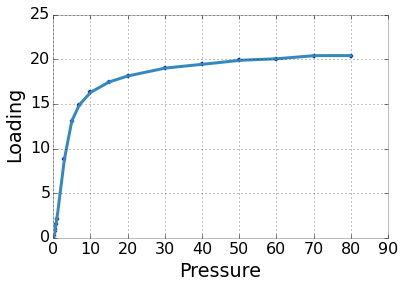

In [55]:
ch3ch3_isotherm = IAST.InterpolatorIsotherm(df_ch3ch3, loading_key="Loading(mol/kg)", 
                                                       pressure_key="Pressure(bar)",
                                                       fill_value=df_ch3ch3["Loading(mol/kg)"].max())
IAST.plot_isotherm(ch3ch3_isotherm)

## Perform IAST at same mixture conditions as binary GCMC simulations

In [56]:
n_mixtures = df_mix.shape[0]
q = np.zeros((2, n_mixtures))  # store component loadings here

for i in range(n_mixtures):
    p = [df_mix["p_CH3CH3(Pa)"].iloc[i] / 100000.0, df_mix["p_CH4(Pa)"].iloc[i] / 100000.0]
    q[:, i] = IAST.IAST(p, [ch3ch3_isotherm, ch4_isotherm], verboseflag=False)

## Compare pyIAST predictions to binary GCMC

In the following plot, the points are the dual component GCMC simulation loadings at the respective ethane mole fraction in the gas phase. The lines are the result of the IAST calculation. The IAST calculations match the binary GCMC simulations very well.

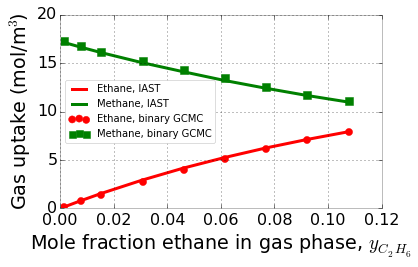

In [57]:
fig = plt.figure()
plt.xlabel('Mole fraction ethane in gas phase, $y_{C_2H_6}$')
plt.ylabel('Gas uptake (mol/m$^3\!$)')
plt.scatter(df_mix['y_CH3CH3'], df_mix['LoadingCH3CH3(mol/kg)'], 
            color=color_key['ethane'], label='Ethane, binary GCMC', s=50)
plt.scatter(df_mix['y_CH3CH3'], df_mix['LoadingCH4(mol/kg)'], 
            color=color_key['methane'], label='Methane, binary GCMC', marker='s', s=50)
plt.plot(df_mix['y_CH3CH3'], q[0, :], color=color_key['ethane'], label='Ethane, IAST')
plt.plot(df_mix['y_CH3CH3'], q[1, :], color=color_key['methane'], label='Methane, IAST')
plt.legend(loc='center left', prop={'size':10})
plt.ylim(ymin=0)
plt.xlim([0, .12])
plt.tight_layout()
plt.show()

## Another sanity check

We use IAST for a three-component mixture of 5 bar methane (all the same!). This should yield the loading at 15 bar.

In [58]:
q = IAST.IAST([5., 5., 5.], [ch4_isotherm, ch4_isotherm, ch4_isotherm], verboseflag=False)
print "Sum of loadings: ", np.sum(q)
print "Loading at 15 bar: ", ch4_isotherm.loading(15.)

Sum of loadings:  6.35637955042
Loading at 15 bar:  6.35637955042


# Reverse IAST

In reverse IAST, we specify the mole fraction in the adsorbed phase and calculate the mole fractions in the gas phase that will yield these adsorbed phase mole fractions. We will test this using the dual GCMC methane/ethane simulations. We define the mole fraction in the adsorbed phase $z_{C_2H_6}$ below. ($z_{CH_4} = 1- z_{C_2H_6}$).

In [59]:
df_mix['z_C2H6'] = df_mix['LoadingCH3CH3(mol/kg)'] / (df_mix['LoadingCH4(mol/kg)'] + df_mix['LoadingCH3CH3(mol/kg)'])
df_mix.head()

,p_CH3CH3(Pa),p_CH4(Pa),LoadingCH3CH3(mol/m3),LoadingCH4(mol/m3),LoadingCH3CH3(mol/kg),LoadingCH4(mol/kg),y_CH3CH3,z_C2H6
0,10000,6490000,86.809663,10245.026337,0.146315,17.267679,0.001538,0.008402
1,50000,6450000,430.043458,9966.957157,0.724825,16.799002,0.007692,0.041362
2,100000,6400000,847.832769,9608.445881,1.428996,16.194742,0.015385,0.081084
3,200000,6300000,1638.684436,9026.572648,2.761953,15.214012,0.030769,0.153647
4,300000,6200000,2365.698251,8490.400097,3.987312,14.310310,0.046154,0.217914


Perform reverse IAST at same adsorbed phase composition as in the binary GCMC simulations.

In [60]:
n_mixtures = df_mix.shape[0]
y = np.zeros((2, n_mixtures))  # store bulk gas mole fractions here
q = np.zeros((2, n_mixtures))  # store component loadings here
P_total = 65.0  # bar, same units as in xe_isotherm and kr_isotherm
for i in range(n_mixtures):
    x = [df_mix['z_C2H6'].iloc[i], 1.0 - df_mix['z_C2H6'].iloc[i]]
    y[:, i], q[:, i] = IAST.reverse_IAST(x, P_total, [ch3ch3_isotherm, ch4_isotherm])

Compare reverse IAST to binary GCMC simulations.

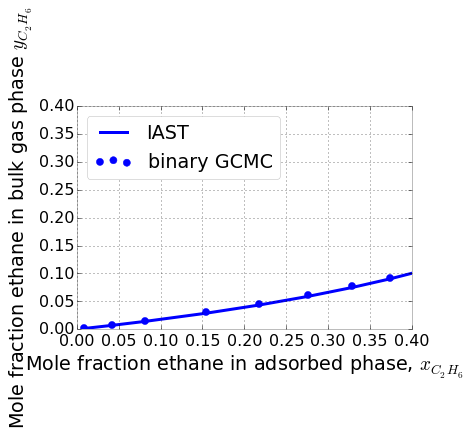

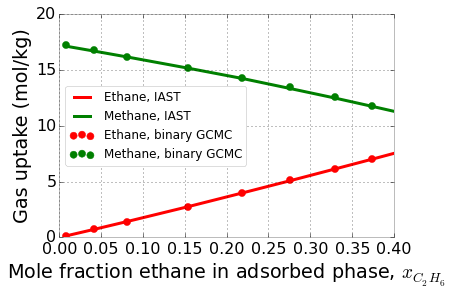

In [61]:
fig = plt.figure()
plt.xlabel('Mole fraction ethane in adsorbed phase, $x_{C_2H_6}$')
plt.ylabel('Mole fraction ethane in bulk gas phase $y_{C_2H_6}$')
plt.scatter(df_mix['z_C2H6'], df_mix['y_CH3CH3'], color='b', label='binary GCMC', s=50)
plt.plot(df_mix['z_C2H6'].values, y[0, :], color='b', label='IAST')
plt.legend(loc='upper left')
plt.xlim([0, .4])
plt.ylim([0, .4])
plt.show()

fig = plt.figure()
plt.xlabel('Mole fraction ethane in adsorbed phase, $x_{C_2H_6}$')
plt.ylabel('Gas uptake (mol/kg)')
plt.scatter(df_mix['z_C2H6'], df_mix['LoadingCH3CH3(mol/kg)'], color=color_key['ethane'], label='Ethane, binary GCMC', s=50)
plt.scatter(df_mix['z_C2H6'], df_mix['LoadingCH4(mol/kg)'], color=color_key['methane'], label='Methane, binary GCMC',s=50)
plt.plot(df_mix['z_C2H6'], q[0, :], color=color_key['ethane'], label='Ethane, IAST')
plt.plot(df_mix['z_C2H6'], q[1, :], color=color_key['methane'], label='Methane, IAST')
plt.legend(loc='center left', prop={'size':12})
plt.xlim([0, .4])
plt.ylim(ymin=0)
plt.show() 